In [1]:
from IPython.core.interactiveshell import InteractiveShell   #Allowing for multiline output
InteractiveShell.ast_node_interactivity = "all"

## Importing Modules and Creating Workflow

In [2]:
import os
import time
from PIL import Image
import numpy as np
import pandas as pd
import pandas_flavor as pf
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from statistics import stdev
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import scikitplot as skplt

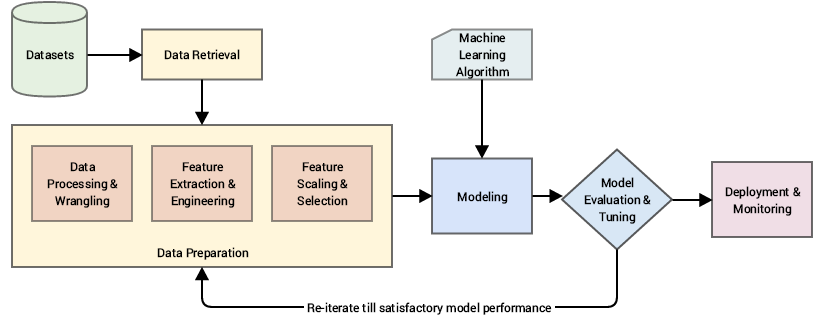

In [3]:
img = Image.open('workflow.png')
display(img)

## Data Exploration

In [4]:
#Reading in different data files and analyzing first few rows of each data set
training_df = pd.read_csv('FoodDelivery.csv') #Airport_codes -> ac
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
training_df.shape # We will split training data into training and validation


(388, 50)

In [6]:
training_df.head()

Age  Gender Marital_Status Occupation  Monthly_Income  \
0   NaN  Female         Single    Student       No Income   
1  24.0  Female         Single    Student  Below Rs.10000   
2  22.0    Male         Single    Student  Below Rs.10000   
3  22.0  Female         Single    Student       No Income   
4  22.0    Male         Single    Student  Below Rs.10000   

  Educational_Qualifications  Family_size  latitude  longitude   Meal(P1)  \
0              Post Graduate            4   12.9766    77.5993  Breakfast   
1                   Graduate            3   12.9770    77.5773     Snacks   
2              Post Graduate            3   12.9551    77.6593      Lunch   
3                   Graduate            6   12.9473    77.5616     Snacks   
4              Post Graduate            4   12.9850    77.5533      Lunch   

  Meal(P2)                          Perference(P1)  \
0    Lunch          Non Veg foods (Lunch / Dinner)   
1   Dinner          Non Veg foods (Lunch / Dinner)   
2   Snacks          Non Veg foods (Lunch / Dinner)   
3   Dinner  Veg foods (Breakfast / Lunch / Dinner)   
4   Dinner          Non Veg foods (Lunch / Dinner)   

                           Perference(P2) Ease_and_convenient     Time_saving  \
0                   Bakery items (snacks)             Neutral         Neutral   
1  Veg foods (Breakfast / Lunch / Dinner)      Strongly agree  Strongly agree   
2                 Ice cream / Cool drinks      Strongly agree  Strongly agree   
3                   Bakery items (snacks)               Agree           Agree   
4  Veg foods (Breakfast / Lunch / Dinner)               Agree           Agree   

  More_restaurant_choices Easy_Payment_option More_Offers_and_Discount  \
0                 Neutral             Neutral                  Neutral   
1          Strongly agree      Strongly agree           Strongly agree   
2          Strongly agree             Neutral                  Neutral   
3          Strongly agree               Agree           Strongly agree   
4                   Agree               Agree                    Agree   

  Good_Food_quality Good_Tracking_system    Self_Cooking  Health_Concern  \
0           Neutral              Neutral         Neutral         Neutral   
1           Neutral                Agree  Strongly agree  Strongly agree   
2          Disagree              Neutral        Disagree         Neutral   
3             Agree                Agree           Agree  Strongly agree   
4           Neutral              Neutral           Agree  Strongly agree   

    Late_Delivery    Poor_Hygiene Bad_past_experience  Unavailability  \
0         Neutral         Neutral             Neutral         Neutral   
1           Agree  Strongly agree      Strongly agree  Strongly agree   
2         Neutral           Agree               Agree           Agree   
3         Neutral           Agree            Disagree        Disagree   
4  Strongly agree           Agree      Strongly agree           Agree   

     Unaffordable Long_delivery_time  \
0         Neutral              Agree   
1  Strongly agree     Strongly agree   
2           Agree              Agree   
3         Neutral              Agree   
4        Disagree     Strongly agree   

  Delay_of_delivery_person_getting_assigned  \
0                                     Agree   
1                            Strongly agree   
2                                     Agree   
3                                     Agree   
4                            Strongly agree   

  Delay_of_delivery_person_picking_up_food Wrong_order_delivered  \
0                                    Agree                 Agree   
1                           Strongly agree        Strongly agree   
2                                    Agree        Strongly agree   
3                                    Agree              Disagree   
4                                  Neutral               Neutral   

     Missing_item Order_placed_by_mistake Influence_of_time  \
0           Agree        

In [7]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 50 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Age                                        379 non-null    float64
 1   Gender                                     388 non-null    object 
 2   Marital_Status                             388 non-null    object 
 3   Occupation                                 388 non-null    object 
 4   Monthly_Income                             388 non-null    object 
 5   Educational_Qualifications                 388 non-null    object 
 6   Family_size                                388 non-null    int64  
 7   latitude                                   388 non-null    float64
 8   longitude                                  388 non-null    float64
 9   Meal(P1)                                   388 non-null    object 
 10  Meal(P2)                  

In [8]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

missing_values_table(training_df)

Your selected dataframe has 50 columns.
There are 1 columns that have missing values.


Missing Values  % of Total Values
Age               9                2.3

## Data Preparation

In [9]:
training_df['orderAgain'].value_counts()


Yes    301
No      87
Name: orderAgain, dtype: int64

In [10]:
def impute_mode(X):
    return training_df[X].fillna(value=training_df[X].mode()[0], inplace=True)
impute_mode('Age')

In [11]:
training_df['Age'].isnull().any()

False

In [41]:
import pandas_profiling
profile = training_df.profile_report(title="Pandas Profiling Report")
profile

In [12]:
train_df, valid_df = train_test_split(training_df,test_size=0.3, stratify= training_df['orderAgain'], random_state= 42)

In [13]:
train_df.shape, valid_df.shape

((271, 50), (117, 50))

In [14]:
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

In [15]:
train_df.columns

Index(['Age', 'Gender', 'Marital_Status', 'Occupation', 'Monthly_Income',
       'Educational_Qualifications', 'Family_size', 'latitude', 'longitude',
       'Meal(P1)', 'Meal(P2)', 'Perference(P1)', 'Perference(P2)',
       'Ease_and_convenient', 'Time_saving', 'More_restaurant_choices',
       'Easy_Payment_option', 'More_Offers_and_Discount', 'Good_Food_quality',
       'Good_Tracking_system', 'Self_Cooking', 'Health_Concern',
       'Late_Delivery', 'Poor_Hygiene', 'Bad_past_experience',
       'Unavailability', 'Unaffordable', 'Long_delivery_time',
       'Delay_of_delivery_person_getting_assigned',
       'Delay_of_delivery_person_picking_up_food', 'Wrong_order_delivered',
       'Missing_item', 'Order_placed_by_mistake', 'Influence_of_time',
       'Order_Time', 'Maximum_wait_time', 'Residence_in_busy_location',
       'Good_Road_Condition', 'Low_quantity_low_time',
       'Delivery_person_ability', 'Influence_of_rating', 'Less_Delivery_time',
       'High_Quality_of_package', '

## Spliting into X and y

In [16]:
X_train = train_df.drop(columns = ['orderAgain'],axis = 1)

y_train = train_df.orderAgain
y_train.replace({'Yes':1,'No':0},inplace = True)


In [17]:
X_valid = train_df.drop(columns = ['orderAgain'],axis = 1)
y_valid= train_df.orderAgain
y_valid.replace({'Yes':1,'No':0},inplace = True)

In [18]:
X_train.shape , y_train.shape , X_valid.shape , y_valid.shape

((271, 49), (271,), (271, 49), (271,))

In [19]:
y_train.head()

0    1
1    1
2    1
3    1
4    1
Name: orderAgain, dtype: int64

In [21]:
from sklearn.preprocessing import OrdinalEncoder

std = StandardScaler()
ord_enc = OrdinalEncoder()
preprocess = make_column_transformer((ord_enc, ['Gender', 'Marital_Status', 'Occupation', 'Monthly_Income',
       'Educational_Qualifications', 'Family_size','Meal(P1)', 'Meal(P2)', 'Perference(P1)', 'Perference(P2)',
       'Ease_and_convenient', 'Time_saving', 'More_restaurant_choices',
       'Easy_Payment_option', 'More_Offers_and_Discount', 'Good_Food_quality',
       'Good_Tracking_system', 'Self_Cooking', 'Health_Concern',
       'Late_Delivery', 'Poor_Hygiene', 'Bad_past_experience',
       'Unavailability', 'Unaffordable', 'Long_delivery_time',
       'Delay_of_delivery_person_getting_assigned',
       'Delay_of_delivery_person_picking_up_food', 'Wrong_order_delivered',
       'Missing_item', 'Order_placed_by_mistake', 'Influence_of_time',
       'Order_Time', 'Maximum_wait_time', 'Residence_in_busy_location',
       'Good_Road_Condition', 'Low_quantity_low_time',
       'Delivery_person_ability', 'Influence_of_rating', 'Less_Delivery_time',
       'High_Quality_of_package', 'Number_of_calls', 'Politeness', 'Freshness',
       'Temperature', 'Good_Taste', 'Good_Quantity']),
(std, ['Age','latitude','longitude']), remainder = 'passthrough')



## Training Model

### XG BOOST Classifier

In [31]:
xgb_clf = make_pipeline(
    preprocess,
    XGBClassifier())

[14:33:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\AKASH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['Gender', 'Marital_Status',
                                                   'Occupation',
                                                   'Monthly_Income',
                                                   'Educational_Qualifications',
                                                   'Family_size', 'Meal(P1)',
                                                   'Meal(P2)', 'Perference(P1)',
                                                   'Perference(P2)',
                                                   'Ease_and_convenient',
                                                   'Time_saving',
                                                   'More_restaurant_choices',
                          

The f1 score for the testing data: 1.0
No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000


Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

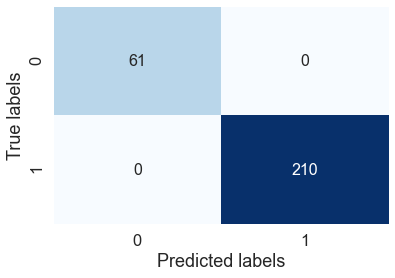

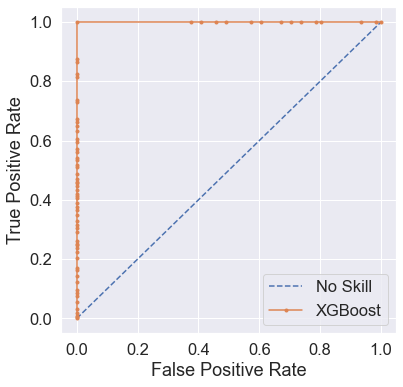

In [38]:
xgb_clf.fit(X_train, y_train)

# Predicting on the test data
pred_test = xgb_clf.predict(X_valid)

#Calculating and printing the f1 score 
f1_test = f1_score(y_valid, pred_test)
print('The f1 score for the testing data:', f1_test)

#Ploting the confusion matrix
conf_matrix(y_valid, pred_test)

lr_probs = xgb_clf.predict_proba(X_valid)
lr_probs = lr_probs[:, 1]

ns_probs = [0 for _ in range(len(y_valid))]

ns_auc = roc_auc_score(y_valid, ns_probs)
lr_auc = roc_auc_score(y_valid, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_valid, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_valid, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()
# show the plot
plt.show()

### Conclusion 


### Overall, the dataset had very little misisng value. We imputed the missing value with the mode.

### The dataset was split on the strata of the target to ensure we had enough instances. 

### Ordinal Encoding was done to the variables to ensure it captures the weight in the repsonses. Strongly Agree being strongest and Strongly Disagree being weakest

### Overall, we ran a simple classifier and a boosted classifier. Given the amount of information in the survey dataset the boosted model performs extremely well with good predicitve power.